In [1]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
import numpy as np
import os
#from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm

In [10]:
n = 2000 # number of bandits
k = 10 # number of arms

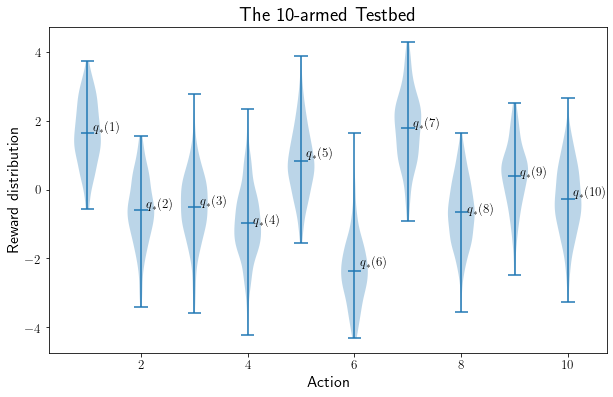

In [12]:
# true value mu = q*(a) of each of the ten actions is N(0, 1)
# actual reward is grey distribution N(q*(a), 1)
np.random.seed(1)
mu = np.random.randn(k) # true value
data = np.random.randn(int(n/k), k) + mu
fig = plt.figure(figsize=(10,6))
plt.rc('font', size=13)
plt.violinplot(dataset = data, showmeans = True)
plt.xlabel("Action", fontsize = 16)
plt.ylabel("Reward distribution", fontsize = 16)
plt.title("The 10-armed Testbed", fontsize = 20)
for i in range(k):
    plt.text(i + 1.1, mu[i], r'$q_*(%0.f)$' %(i+1))
fig.savefig('/Users/yuxin/Desktop/plot/mab_k10.pdf', bbox_inches='tight')
#plt.close()

In [28]:
class MultiArmedBandits:
    def __init__(self, k = 10, epsilon = 0, initial = 0, true_expected_reward = 0, step_size = None, ucb = None, gradient = None, baseline = None, num_steps = 1000, num_runs = 2000):
        self.k = k
        self.epsilon = epsilon
        self.initial = initial
        self.initial_mu = true_expected_reward
        self.step_size = step_size
        self.ucb_c = ucb # degree of exploration
        self.gradient = gradient # step_size for gradient bandit algorithm
        self.baseline = baseline
        self.num_steps = num_steps
        self.num_runs = num_runs
        
        
    def new_bandit(self):
        self.q = np.empty(self.k)
        self.q.fill(self.initial)
        self.action_count = np.zeros(self.k)
        self.mu = np.random.randn(self.k) + self.initial_mu
        self.action_optimal = np.argmax(self.mu)
        self.reward_episode = np.zeros(self.num_steps)
        self.action_episode = np.zeros(self.num_steps)
        if self.gradient:
            self.h = np.zeros(self.k)
            self.prev_rewards_bar = 0
            self.rewards_bar = 0
        
    # default: 1000 steps make up one episode/run    
    def episode(self):
        for step in range(self.num_steps):
            if np.random.random() < self.epsilon: # choose randomly
                action = np.random.randint(1,self.k)
            elif self.ucb_c: # select actions according to UCB formula
                if min(self.action_count) == 0: # do not add small value to action_count only for edge cases
                    action = np.random.choice(np.where(self.action_count == 0)[0])
                else:
                    ucb_action = self.q + self.ucb_c * np.sqrt(np.divide(np.log(step + 1), self.action_count))
                    action = np.random.choice(np.where(ucb_action == max(ucb_action))[0])
            elif self.gradient: # gradient bandit: only consider numerical preference
                h_exp = np.exp(self.h)
                pi = h_exp/np.sum(h_exp)
                action = np.random.choice(np.arange(10), p = pi)
            else: # choose a random action that maximise Q(a)
                action = np.random.choice(np.where(self.q == max(self.q))[0])
            self.action_count[action] += 1
            
            if action == self.action_optimal:
                self.action_episode[step] = 1

            # true value mu doesn't change at each time step for each bandit problem
            # reward at each step by choosing an action
            reward = np.random.randn() + self.mu[action]
            self.reward_episode[step] = reward
            
            if self.step_size: # apply constant step-size
                self.q[action] += self.step_size * (reward - self.q[action])
            elif self.gradient: # update h based on stochastic gradient ascent idea
                h_action = np.zeros(self.k)
                h_action[action] = 1
                
#                 ### v1. implemented as description in the book:
#                 ### when updating H_{t+1}, use \bar{R_t} as average of all rewards up to but not include time t
#                 self.h += self.gradient * (reward - self.prev_rewards_bar) * (h_action - pi) # update h
#                 if self.baseline: # if no baseline, q is constantly 0
#                     self.prev_rewards_bar = self.rewards_bar # average of all rewards up to but not include time t
#                     self.rewards_bar += (reward - self.rewards_bar) / (step + 1)
                    
                ### v2. implemented as middle case between v1 & v3
                ### when updating H_{t+1}, use \bar{R_t} as average of all rewards up to and include time t
                self.h += self.gradient * (reward - self.rewards_bar) * (h_action - pi) # update h
                if self.baseline: # if no baseline, q is constantly 0
                    self.rewards_bar += (reward - self.rewards_bar) / (step + 1)
                    
#                 ### v3. wrong order, plot most similar to the book and another replication; checked Lisp code
#                 ### when updating H_{t+1}, use \bar{R_{t+1}} as average of all rewards up to and include time t+1
#                 if self.baseline: # if no baseline, q is constantly 0
#                     self.rewards_bar += (reward - self.rewards_bar) / (step + 1) # average of all rewards
#                 self.h += self.gradient * (reward - self.rewards_bar) * (h_action - pi) # update h, eq. 2.12

            else: 
                # incremental update of action value q: sample average
                self.q[action] += (reward - self.q[action]) / self.action_count[action]
        return self.reward_episode, self.action_episode
    
    # default: average of 2000 runs
    def simulate(self):
        average_reward = np.zeros((self.num_runs, self.num_steps))
        action_percentage = np.zeros((self.num_runs, self.num_steps)) ### waste of space, can incrementally update???
        for run in tqdm(range(self.num_runs)):
            self.new_bandit()
            average_reward[run], action_percentage[run] = self.episode()
        return [np.mean(average_reward, axis = 0), np.mean(action_percentage, axis = 0)]

# 2.3 $\epsilon$-greedy

In [8]:
epsilon = [0, 0.01, 0.1, 0.2]
epsilon_bandits = np.array([MultiArmedBandits(epsilon = eps).simulate() for eps in epsilon]) # default shape: (3,2,1000)

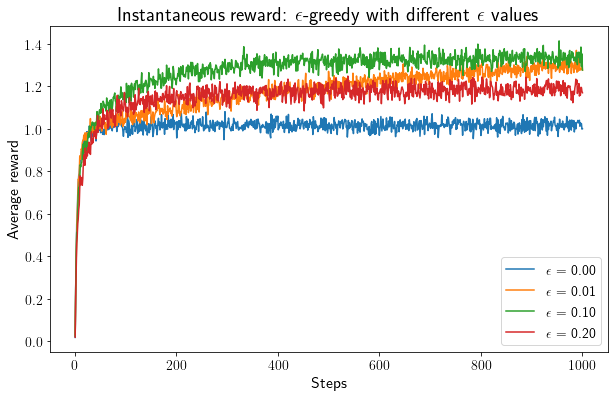

In [32]:
fig = plt.figure(figsize=(10,6))
plt.rc('font', size=14)
for eps, reward in zip(epsilon, epsilon_bandits[:,0,:]):
        plt.plot(np.arange(1, 1001), reward, label=r'$\epsilon$ = %.02f' % (eps))
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("Average reward", fontsize = 16)
plt.title(r"Instantaneous reward: $\epsilon$-greedy with different $\epsilon$ values", fontsize = 20)
plt.legend()

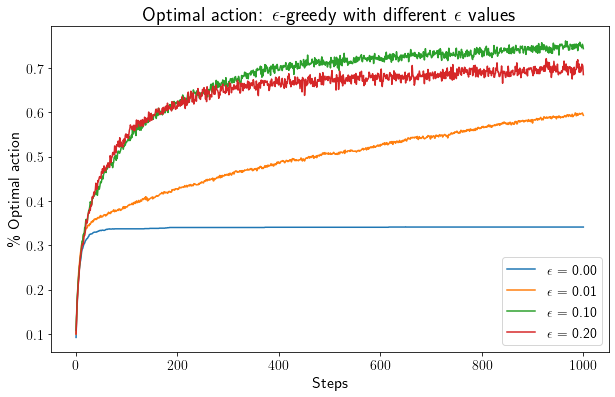

In [12]:
fig = plt.figure(figsize=(10,6))
plt.rc('font', size=14)
for eps, action in zip(epsilon, epsilon_bandits[:,1,:]):
        plt.plot(np.arange(1, 1001), action, label=r'$\epsilon$ = %.02f' % (eps))
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("\% Optimal action", fontsize = 16)
plt.title(r"Optimal action: $\epsilon$-greedy with different $\epsilon$ values", fontsize = 20)
plt.legend()

## 2.6 Optimistic Initial Values

In [17]:
# return default shape (2,1000) for average reward and % optimal action
bandit_optimistic_baseline = MultiArmedBandits(epsilon = 0.1, step_size = 0.1).simulate() # Q1 = 0, epsilon = 0.1
# bandit_optimistic_01 = MultiArmedBandits(initial = 0.1, step_size = 0.1).simulate() # Q1 = 0.5, epsilon = 0
bandit_optimistic_05 = MultiArmedBandits(initial = 0.5, step_size = 0.1).simulate() # Q1 = 0.5, epsilon = 0
bandit_optimistic_1 = MultiArmedBandits(initial = 1, step_size = 0.1).simulate() # Q1 = 1, epsilon = 0
bandit_optimistic_3 = MultiArmedBandits(initial = 3, step_size = 0.1).simulate() # Q1 = 3, epsilon = 0
bandit_optimistic_5 = MultiArmedBandits(initial = 5, step_size = 0.1).simulate() # Q1 = 5, epsilon = 0
bandit_optimistic_10 = MultiArmedBandits(initial = 10, step_size = 0.1).simulate() # Q1 = 10, epsilon = 0

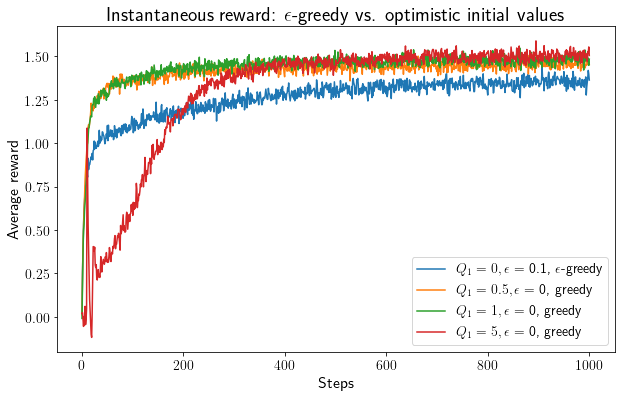

In [33]:
fig = plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.plot(np.arange(1, 1001), bandit_optimistic_baseline[0], label=r'$Q_1 = 0, \epsilon$ = 0.1, $\epsilon$-greedy')
plt.plot(np.arange(1, 1001), bandit_optimistic_05[0], label=r'$Q_1 = 0.5, \epsilon$ = 0, greedy')
plt.plot(np.arange(1, 1001), bandit_optimistic_1[0], label=r'$Q_1 = 1, \epsilon$ = 0, greedy')
plt.plot(np.arange(1, 1001), bandit_optimistic_5[0], label=r'$Q_1 = 5, \epsilon$ = 0, greedy')
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("Average reward", fontsize = 16)
plt.title(r"Instantaneous reward: $\epsilon$-greedy vs. optimistic initial values", fontsize = 20)
plt.legend()

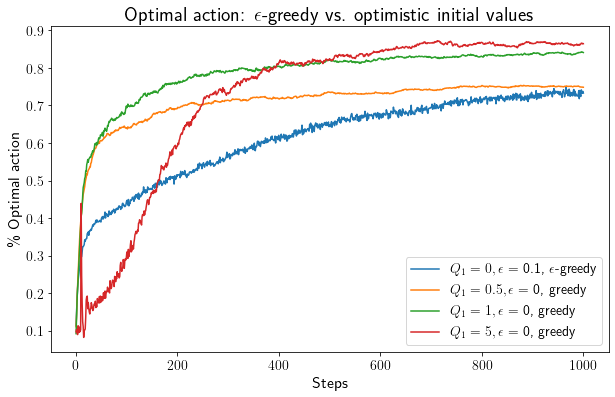

In [25]:
fig = plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.plot(np.arange(1, 1001), bandit_optimistic_baseline[1], label=r'$Q_1 = 0, \epsilon$ = 0.1, $\epsilon$-greedy')
plt.plot(np.arange(1, 1001), bandit_optimistic_05[1], label=r'$Q_1 = 0.5, \epsilon$ = 0, greedy')
plt.plot(np.arange(1, 1001), bandit_optimistic_1[1], label=r'$Q_1 = 1, \epsilon$ = 0, greedy')
plt.plot(np.arange(1, 1001), bandit_optimistic_5[1], label=r'$Q_1 = 5, \epsilon$ = 0, greedy')
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("\% Optimal action", fontsize = 16)
plt.title(r"Optimal action: $\epsilon$-greedy vs. optimistic initial values", fontsize = 20)
plt.legend()

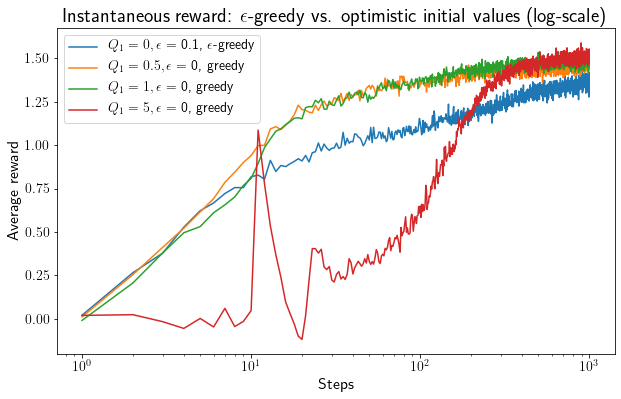

In [34]:
fig, ax = plt.subplots(figsize=(10,6))  
ax.set_xscale('log')
plt.plot(np.arange(1, 1001), bandit_optimistic_baseline[0], label=r'$Q_1 = 0, \epsilon$ = 0.1, $\epsilon$-greedy')
plt.plot(np.arange(1, 1001), bandit_optimistic_05[0], label=r'$Q_1 = 0.5, \epsilon$ = 0, greedy')
plt.plot(np.arange(1, 1001), bandit_optimistic_1[0], label=r'$Q_1 = 1, \epsilon$ = 0, greedy')
plt.plot(np.arange(1, 1001), bandit_optimistic_5[0], label=r'$Q_1 = 5, \epsilon$ = 0, greedy')
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("Average reward", fontsize = 16)
plt.title(r"Instantaneous reward: $\epsilon$-greedy vs. optimistic initial values (log-scale)", fontsize = 20)
plt.legend()

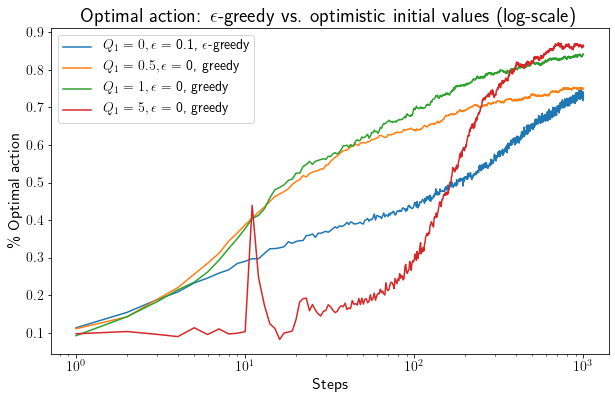

In [27]:
fig, ax = plt.subplots(figsize=(10,6))  
ax.set_xscale('log')
plt.plot(np.arange(1, 1001), bandit_optimistic_baseline[1], label=r'$Q_1 = 0, \epsilon$ = 0.1, $\epsilon$-greedy')
plt.plot(np.arange(1, 1001), bandit_optimistic_05[1], label=r'$Q_1 = 0.5, \epsilon$ = 0, greedy')
plt.plot(np.arange(1, 1001), bandit_optimistic_1[1], label=r'$Q_1 = 1, \epsilon$ = 0, greedy')
plt.plot(np.arange(1, 1001), bandit_optimistic_5[1], label=r'$Q_1 = 5, \epsilon$ = 0, greedy')
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("\% Optimal action", fontsize = 16)
plt.title(r"Optimal action: $\epsilon$-greedy vs. optimistic initial values (log-scale)", fontsize = 20)
plt.legend()

In [21]:
# return default shape (2,1000) for average reward and % optimal action
bandit_optimistic_baseline = MultiArmedBandits(epsilon = 0.1, step_size = 0.1).simulate() # Q1 = 0, epsilon = 0.1
bandit_optimistic_1 = MultiArmedBandits(initial = 1, step_size = 0.1).simulate() # Q1 = 1, epsilon = 0
bandit_optimistic_3 = MultiArmedBandits(initial = 3, step_size = 0.1).simulate() # Q1 = 3, epsilon = 0
bandit_optimistic_5 = MultiArmedBandits(initial = 5, step_size = 0.1).simulate() # Q1 = 5, epsilon = 0
bandit_optimistic_10 = MultiArmedBandits(initial = 10, step_size = 0.1).simulate() # Q1 = 10, epsilon = 0

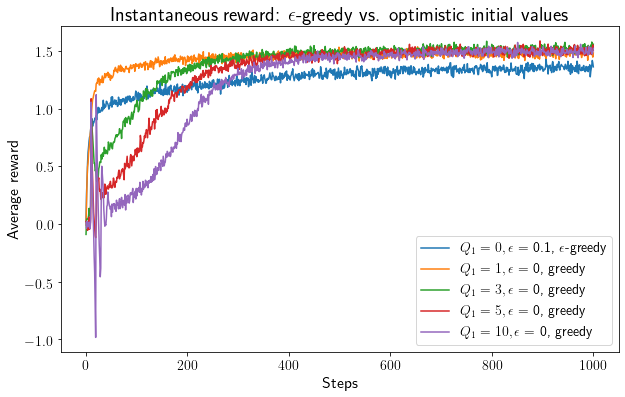

In [35]:
fig = plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.plot(np.arange(1, 1001), bandit_optimistic_baseline[0], label=r'$Q_1 = 0, \epsilon$ = 0.1, $\epsilon$-greedy')
plt.plot(np.arange(1, 1001), bandit_optimistic_1[0], label=r'$Q_1 = 1, \epsilon$ = 0, greedy') # extra experiment
plt.plot(np.arange(1, 1001), bandit_optimistic_3[0], label=r'$Q_1 = 3, \epsilon$ = 0, greedy') # extra experiment
plt.plot(np.arange(1, 1001), bandit_optimistic_5[0], label=r'$Q_1 = 5, \epsilon$ = 0, greedy')
plt.plot(np.arange(1, 1001), bandit_optimistic_10[0], label=r'$Q_1 = 10, \epsilon$ = 0, greedy') # extra experiment
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("Average reward", fontsize = 16)
plt.title(r"Instantaneous reward: $\epsilon$-greedy vs. optimistic initial values", fontsize = 20)
plt.legend()

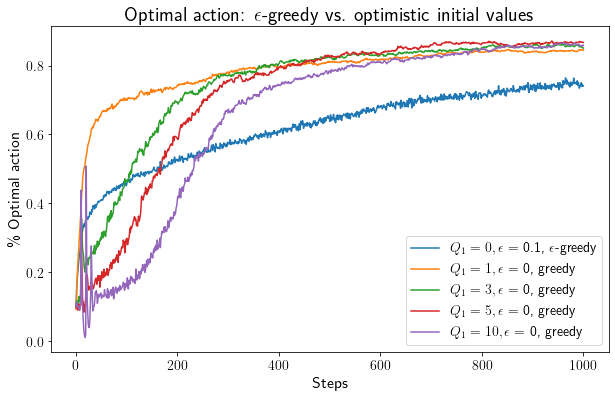

In [41]:
fig = plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.plot(np.arange(1, 1001), bandit_optimistic_baseline[1], label=r'$Q_1 = 0, \epsilon$ = 0.1, $\epsilon$-greedy')
plt.plot(np.arange(1, 1001), bandit_optimistic_1[1], label=r'$Q_1 = 1, \epsilon$ = 0, greedy') # extra experiment
plt.plot(np.arange(1, 1001), bandit_optimistic_3[1], label=r'$Q_1 = 3, \epsilon$ = 0, greedy') # extra experiment
plt.plot(np.arange(1, 1001), bandit_optimistic_5[1], label=r'$Q_1 = 5, \epsilon$ = 0, greedy')
plt.plot(np.arange(1, 1001), bandit_optimistic_10[1], label=r'$Q_1 = 10, \epsilon$ = 0, greedy') # extra experiment
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("\% Optimal action", fontsize = 16)
plt.title(r"Optimal action: $\epsilon$-greedy vs. optimistic initial values", fontsize = 20)
plt.legend()

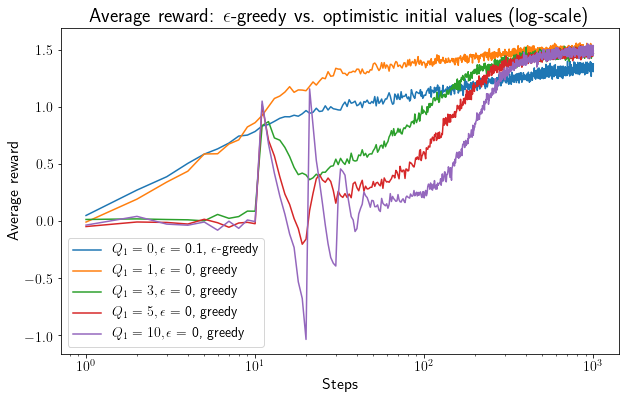

In [38]:
fig, ax = plt.subplots(figsize=(10,6))  
ax.set_xscale('log')
plt.plot(np.arange(1, 1001), bandit_optimistic_baseline[0], label=r'$Q_1 = 0, \epsilon$ = 0.1, $\epsilon$-greedy')
plt.plot(np.arange(1, 1001), bandit_optimistic_1[0], label=r'$Q_1 = 1, \epsilon$ = 0, greedy') # extra experiment
plt.plot(np.arange(1, 1001), bandit_optimistic_3[0], label=r'$Q_1 = 3, \epsilon$ = 0, greedy') # extra experiment
plt.plot(np.arange(1, 1001), bandit_optimistic_5[0], label=r'$Q_1 = 5, \epsilon$ = 0, greedy')
plt.plot(np.arange(1, 1001), bandit_optimistic_10[0], label=r'$Q_1 = 10, \epsilon$ = 0, greedy') # extra experiment
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("Average reward", fontsize = 16)
plt.title(r"Average reward: $\epsilon$-greedy vs. optimistic initial values (log-scale)", fontsize = 20)
plt.legend()

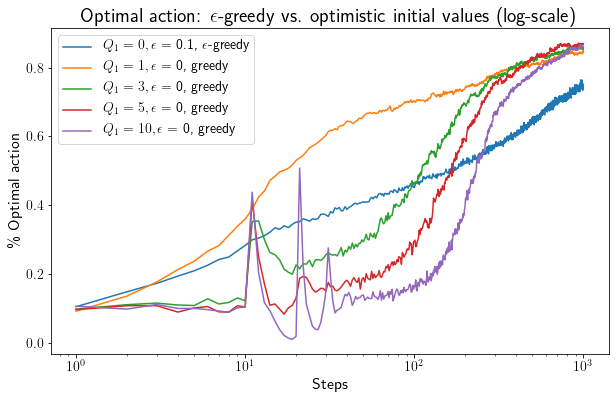

In [40]:
fig, ax = plt.subplots(figsize=(10,6))  
ax.set_xscale('log')
plt.plot(np.arange(1, 1001), bandit_optimistic_baseline[1], label=r'$Q_1 = 0, \epsilon$ = 0.1, $\epsilon$-greedy')
plt.plot(np.arange(1, 1001), bandit_optimistic_1[1], label=r'$Q_1 = 1, \epsilon$ = 0, greedy') # extra experiment
plt.plot(np.arange(1, 1001), bandit_optimistic_3[1], label=r'$Q_1 = 3, \epsilon$ = 0, greedy') # extra experiment
plt.plot(np.arange(1, 1001), bandit_optimistic_5[1], label=r'$Q_1 = 5, \epsilon$ = 0, greedy')
plt.plot(np.arange(1, 1001), bandit_optimistic_10[1], label=r'$Q_1 = 10, \epsilon$ = 0, greedy') # extra experiment
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("\% Optimal action", fontsize = 16)
plt.title(r"Optimal action: $\epsilon$-greedy vs. optimistic initial values (log-scale)", fontsize = 20)
plt.legend()

## 2.7 Upper-Confidence-Bound Action Selection

In [36]:
# return default shape (2,1000) for average reward and % optimal action
bandit_ucb_baseline = MultiArmedBandits(epsilon = 0.1).simulate() # epsilon = 0.1, ucb_c = 0
bandit_ucb_05 = MultiArmedBandits(ucb = 0.5).simulate() # epsilon = 0, ucb_c = 0.5
bandit_ucb_1 = MultiArmedBandits(ucb = 1).simulate() # epsilon = 0, ucb_c = 1
bandit_ucb_2 = MultiArmedBandits(ucb = 2).simulate() # epsilon = 0, ucb_c = 2
bandit_ucb_4 = MultiArmedBandits(ucb = 4).simulate() # epsilon = 0, ucb_c = 4

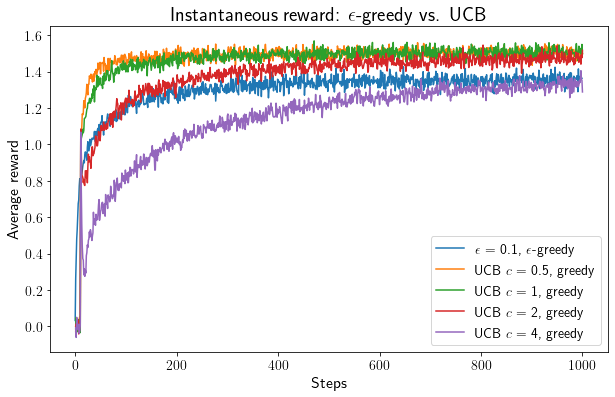

In [37]:
fig = plt.figure(figsize=(10,6))
plt.plot(bandit_ucb_baseline[0], label=r'$\epsilon$ = 0.1, $\epsilon$-greedy')

plt.plot(np.arange(1, 1001), bandit_ucb_05[0], label=r'UCB $c$ = 0.5, greedy') # extra experiment
plt.plot(np.arange(1, 1001), bandit_ucb_1[0], label=r'UCB $c$ = 1, greedy') # extra experiment
plt.plot(np.arange(1, 1001), bandit_ucb_2[0], label=r'UCB $c$ = 2, greedy')
plt.plot(np.arange(1, 1001), bandit_ucb_4[0], label=r'UCB $c$ = 4, greedy') # extra experiment
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("Average reward", fontsize = 16)
plt.title(r"Instantaneous reward: $\epsilon$-greedy vs. UCB", fontsize = 20)
plt.legend()

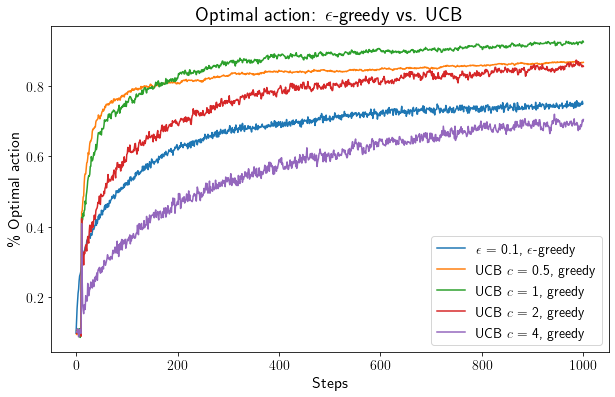

In [51]:
fig = plt.figure(figsize=(10,6))
plt.plot(bandit_ucb_baseline[1], label=r'$\epsilon$ = 0.1, $\epsilon$-greedy')

plt.plot(np.arange(1, 1001), bandit_ucb_05[1], label=r'UCB $c$ = 0.5, greedy') # extra experiment
plt.plot(np.arange(1, 1001), bandit_ucb_1[1], label=r'UCB $c$ = 1, greedy') # extra experiment
plt.plot(np.arange(1, 1001), bandit_ucb_2[1], label=r'UCB $c$ = 2, greedy')
plt.plot(np.arange(1, 1001), bandit_ucb_4[1], label=r'UCB $c$ = 4, greedy') # extra experiment
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("\% Optimal action", fontsize = 16)
plt.title(r"Optimal action: $\epsilon$-greedy vs. UCB", fontsize = 20)
plt.legend() 

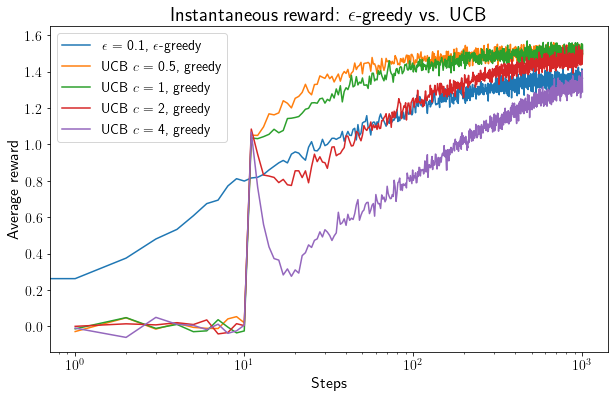

In [38]:
fig, ax = plt.subplots(figsize=(10,6))  
ax.set_xscale('log')

plt.plot(bandit_ucb_baseline[0], label=r'$\epsilon$ = 0.1, $\epsilon$-greedy')

plt.plot(np.arange(1, 1001), bandit_ucb_05[0], label=r'UCB $c$ = 0.5, greedy') # extra experiment
plt.plot(np.arange(1, 1001), bandit_ucb_1[0], label=r'UCB $c$ = 1, greedy') # extra experiment
plt.plot(np.arange(1, 1001), bandit_ucb_2[0], label=r'UCB $c$ = 2, greedy')
plt.plot(np.arange(1, 1001), bandit_ucb_4[0], label=r'UCB $c$ = 4, greedy') # extra experiment
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("Average reward", fontsize = 16)
plt.title(r"Instantaneous reward: $\epsilon$-greedy vs. UCB", fontsize = 20)
plt.legend()

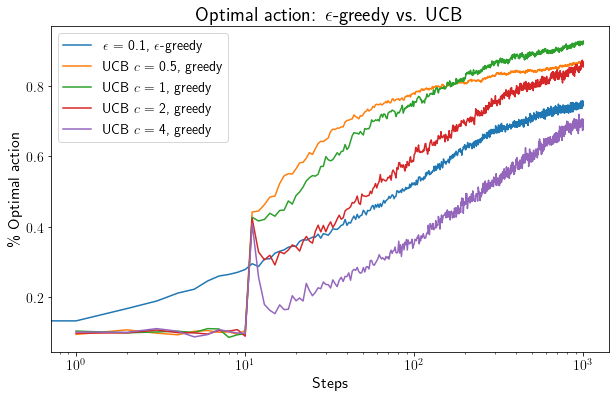

In [53]:
fig, ax = plt.subplots(figsize=(10,6))  
ax.set_xscale('log')

plt.plot(bandit_ucb_baseline[1], label=r'$\epsilon$ = 0.1, $\epsilon$-greedy')

plt.plot(np.arange(1, 1001), bandit_ucb_05[1], label=r'UCB $c$ = 0.5, greedy') # extra experiment
plt.plot(np.arange(1, 1001), bandit_ucb_1[1], label=r'UCB $c$ = 1, greedy') # extra experiment
plt.plot(np.arange(1, 1001), bandit_ucb_2[1], label=r'UCB $c$ = 2, greedy')
plt.plot(np.arange(1, 1001), bandit_ucb_4[1], label=r'UCB $c$ = 4, greedy') # extra experiment
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("\% Optimal action", fontsize = 16)
plt.title(r"Optimal action: $\epsilon$-greedy vs. UCB", fontsize = 20)
plt.legend() 

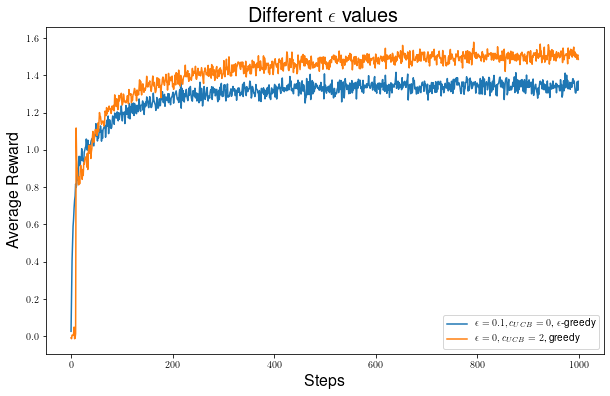

In [455]:
# note the spike
plt.figure(figsize=(10,6))
plt.plot(bandit_ucb_baseline[0], label=r'$\epsilon = 0.1, c_{UCB} = 0$, $\epsilon$-greedy')
plt.plot(bandit_ucb_2[0], label=r'$\epsilon = 0, c_{UCB} = 2$, greedy')
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("Average Reward", fontsize = 16)
plt.title(r"Different $\epsilon$ values", fontsize = 20)
plt.legend()

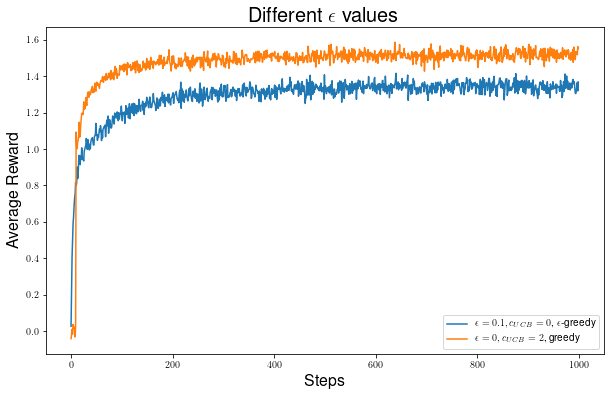

In [456]:
# does not fall much after spike
plt.figure(figsize=(10,6))
plt.plot(bandit_ucb_baseline[0], label=r'$\epsilon = 0.1, c_{UCB} = 0$, $\epsilon$-greedy')
plt.plot(bandit_ucb_1[0], label=r'$\epsilon = 0, c_{UCB} = 2$, greedy')
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("Average Reward", fontsize = 16)
plt.title(r"Different $\epsilon$ values", fontsize = 20)
plt.legend()

## 2.8 Gradient Bandit Algorithm

In [39]:
# return default shape (2,1000) for average reward and % optimal action
bandit_gradient_gradient01_baseline = MultiArmedBandits(true_expected_reward = 4, baseline = True, gradient = 0.1).simulate()
bandit_gradient_gradient04_baseline = MultiArmedBandits(true_expected_reward = 4, baseline = True, gradient = 0.4).simulate()
bandit_gradient_gradient01_no_baseline = MultiArmedBandits(true_expected_reward = 4, gradient = 0.1).simulate()
bandit_gradient_gradient04_no_baseline = MultiArmedBandits(true_expected_reward = 4, gradient = 0.4).simulate()


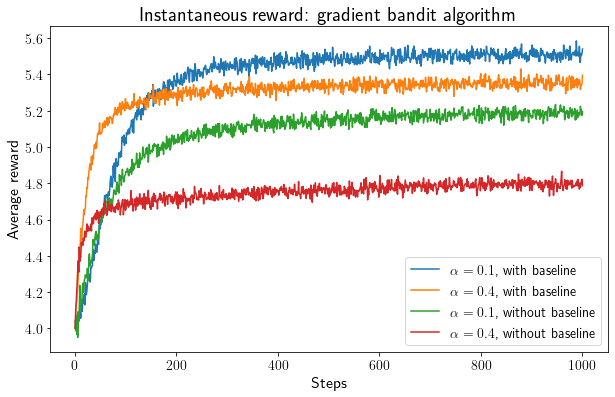

In [40]:
fig = plt.figure(figsize=(10,6))
plt.plot(np.arange(1, 1001), bandit_gradient_gradient01_baseline[0], label=r'$\alpha = 0.1$, with baseline')
plt.plot(np.arange(1, 1001), bandit_gradient_gradient04_baseline[0], label=r'$\alpha = 0.4$, with baseline')
plt.plot(np.arange(1, 1001), bandit_gradient_gradient01_no_baseline[0], label=r'$\alpha = 0.1$, without baseline')
plt.plot(np.arange(1, 1001), bandit_gradient_gradient04_no_baseline[0], label=r'$\alpha = 0.4$, without baseline')
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("Average reward", fontsize = 16)
plt.title(r"Instantaneous reward: gradient bandit algorithm", fontsize = 20)
plt.legend()

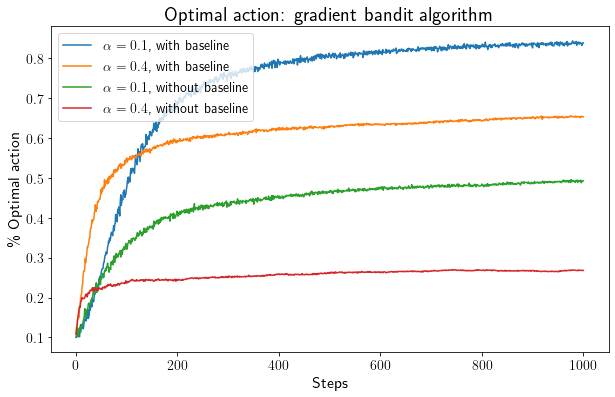

In [31]:
fig = plt.figure(figsize=(10,6))
plt.plot(np.arange(1, 1001), bandit_gradient_gradient01_baseline[1], label=r'$\alpha = 0.1$, with baseline')
plt.plot(np.arange(1, 1001), bandit_gradient_gradient04_baseline[1], label=r'$\alpha = 0.4$, with baseline')
plt.plot(np.arange(1, 1001), bandit_gradient_gradient01_no_baseline[1], label=r'$\alpha = 0.1$, without baseline')
plt.plot(np.arange(1, 1001), bandit_gradient_gradient04_no_baseline[1], label=r'$\alpha = 0.4$, without baseline')
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("\% Optimal action", fontsize = 16)
plt.title(r"Optimal action: gradient bandit algorithm", fontsize = 20)
plt.legend()

## plot for the book

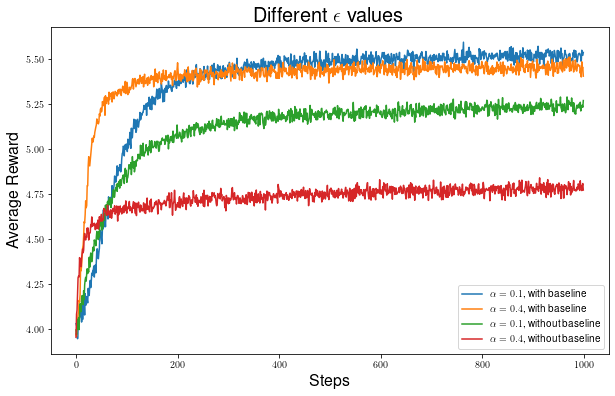

In [543]:
plt.figure(figsize=(10,6))
plt.plot(bandit_gradient_gradient01_baseline[0], label=r'$\alpha = 0.1$, with baseline')
plt.plot(bandit_gradient_gradient04_baseline[0], label=r'$\alpha = 0.4$, with baseline')
plt.plot(bandit_gradient_gradient01_no_baseline[0], label=r'$\alpha = 0.1$, without baseline')
plt.plot(bandit_gradient_gradient04_no_baseline[0], label=r'$\alpha = 0.4$, without baseline')
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("Average Reward", fontsize = 16)
plt.title(r"Different $\epsilon$ values", fontsize = 20)
plt.legend()

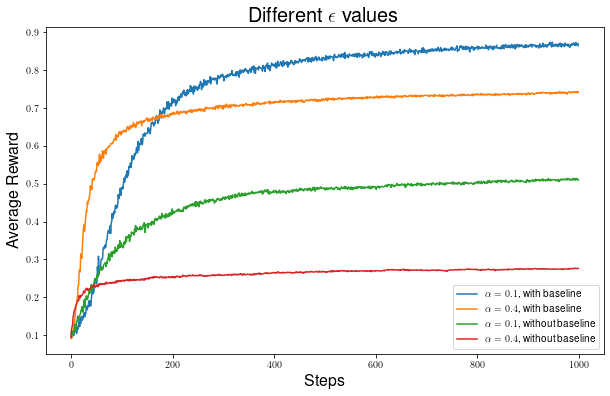

In [544]:
plt.figure(figsize=(10,6))
plt.plot(bandit_gradient_gradient01_baseline[1], label=r'$\alpha = 0.1$, with baseline')
plt.plot(bandit_gradient_gradient04_baseline[1], label=r'$\alpha = 0.4$, with baseline')
plt.plot(bandit_gradient_gradient01_no_baseline[1], label=r'$\alpha = 0.1$, without baseline')
plt.plot(bandit_gradient_gradient04_no_baseline[1], label=r'$\alpha = 0.4$, without baseline')
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("Average Reward", fontsize = 16)
plt.title(r"Different $\epsilon$ values", fontsize = 20)
plt.legend()

## 2.10 Parameter study
Average reward over first 1000 steps: $\epsilon$ - greedy, UCB, gradient bandit, greedy with optimistic intialisation $\alpha$ = 0.1

In [603]:
def generate_param(low, high):
    return list(map(lambda x: pow(2, x), np.arange(low, high, dtype=float)))

labels = [r'$\epsilon$-greedy', 'gradient bandit', 'UCB', r'greedy with optimistic intialisation $\alpha$ = 0.1']
parameters = [generate_param(-7, -1), generate_param(-5, 3), generate_param(-4, 3), generate_param(-2, 3)]

# for each parameter and bandit problem, return a single value of the average reward over first 1000 steps
bandits = [lambda eps: MultiArmedBandits(epsilon = eps).simulate()[0],
           lambda alpha: MultiArmedBandits(baseline = True, gradient = alpha).simulate()[0],
           lambda c: MultiArmedBandits(ucb = c).simulate()[0],
           lambda initial: MultiArmedBandits(initial = initial, step_size = 0.1).simulate()[0]]

In [605]:
results = []
for i in range(len(labels)):
    for param in parameters[i]:
        results.append(np.mean(bandits[i](param)))

1.1534083340022594


1.2287735777352113


1.3032871309855545


1.3011376322239194


1.2514263203796945


1.0869774941598902


1.057744199679994


1.2647549751558953


1.393726860538755


1.3945846504504498


1.3709185876775072


1.3063350524625224


1.1315977665158632


0.928077779452363


1.4089051012740328


1.4114041153496248


1.4591408138824786


1.4643581173931834


1.4680063606595541


1.3906417944148075


1.1636355834181156


1.311668612931379


1.4045453099020975


1.4596037144360443


1.4004677448309852


1.3095960845967738


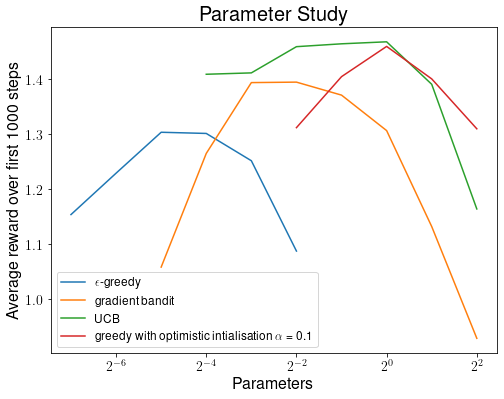

In [636]:
fig, ax = plt.subplots(figsize=(8,6))  
ax.set_xscale('log', basex=2)
i = 0
for label, param in zip(labels, parameters):
    l = len(param)
    plt.plot(param, results[i:i+l], label=label)
    i += l
plt.xlabel("Parameters", fontsize = 16)
plt.ylabel("Average reward over first 1000 steps", fontsize = 16)
plt.title("Parameter Study", fontsize = 20)
plt.legend()